# Fuel Consumption EDA & Prediction ⛽🚘
- [link](https://www.kaggle.com/code/sercanyesiloz/fuel-consumption-eda-prediction)

![Untitled](https://media.giphy.com/media/l2R0e9y6A304JkFOg/source.gif)

In [1]:
# !pip install plotly
# !pip install nb_black
# !pip install catboost

- `import os`: 운영체제(OS : Operating System) 제어
- `import warnings`: 경고 제어
- `from scipy`: 과학기술계산을 위한 Python 라이브러리. NumPy, Matplotlib, pandas, SymPy와 연계되어 있다
- `from scipy.stats`: stats 서브패키지는 확률분포 분석을 위한 다양한 기능을 제공
    - [`norm`(가우시안 정규분포)](https://namyoungkim.github.io/scipy/probability/2017/09/04/scipy/), [`skew`(왜도)](https://mizykk.tistory.com/73)
- `sklearn.base.clone`: Construct a new unfitted estimator with the same parameters.
- `sklearn.pipeline`: 생산라인에서 동시에 여러 공정 프로세스를 효율적이게 하는 것처럼, 머신러닝에서 모델을 가속, 재사용, 관리 및 배포하는 프로세스를 구현하고 표준화하는 것을 의미 -> 파이프라인을 사용하면 데이터 전처리와 모델 학습, 예측까지 한번에 가능하여 코드가 간결해짐([출처](https://study2give.tistory.com/entry/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-%ED%8C%8C%EC%9D%B4%ED%94%84%EB%9D%BC%EC%9D%B8Pipeline))

In [2]:
import os
import warnings
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.metrics import (r2_score,
                             mean_squared_error,
                             mean_absolute_percentage_error,
                             mean_absolute_error,
                             mean_squared_log_error)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, StandardScaler

In [3]:
#Visualization
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import colors
import plotly.graph_objs as go
from plotly.offline import iplot
from plotly.subplots import make_subplots

In [4]:
#ML Models
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import (LinearRegression,
                                  Ridge,
                                  Lasso,
                                  ElasticNet)

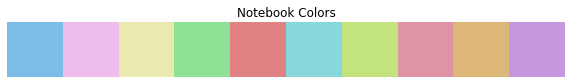

<IPython.core.display.Javascript object>

In [5]:
%matplotlib inline
%load_ext nb_black
warnings.filterwarnings("ignore")
colors = ['#7DBCE6','#EEBDEE','#EAEAAF','#8FE195','#E28181',
          '#87D8DB','#C2E37D','#DF93A4','#DCB778','#C497DE']
sns.palplot(sns.color_palette(colors))
plt.title('Notebook Colors', size = 12)
plt.axis('off')
plt.show()

### Load and Check Data
- na_values : 해당 값을 NA/NaN 값으로 변경

Additional strings to recognize as NA/NaN. If dict passed, specific per-column NA values.  By default the following values are interpreted as NaN: '', '#N/A', '#N/A N/A', '#NA', '-1.#IND', '-1.#QNAN', '-NaN', '-nan', '1.#IND', '1.#QNAN', '<NA>', 'N/A', 'NA', 'NULL', 'NaN', 'n/a', 'nan', 'null'.

In [6]:
auto = pd.read_csv('auto-mpg.csv', na_values = "?")
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


<IPython.core.display.Javascript object>

In [7]:
# car name
def auto_preprocess(dataframe): 
    df_ = dataframe.copy()
    auto_misspelled = {'chevroelt': 'chevrolet',
                        'chevy': 'chevrolet',
                        'vokswagen': 'volkswagen',
                        'vw': 'volkswagen',
                        'hi': 'harvester',
                        'maxda': 'mazda',
                        'toyouta': 'toyota',
                        'mercedes-benz': 'mercedes'}
    
    df_['make'] = [auto_misspelled[key].title() if key in auto_misspelled else
                   key.title() for key in [i.split()[0] for i in df_['car name']]]
    
    # for key in [i.split()[0] for i in df_['car name']]:
    #     if key in auto_misspelled:
    #         auto_misspelled[key].title() 
    #     else:
    #         key

    df_['name'] = [' '.join(i.split()[1:]).title() for i in df_['car name']]
    
    df_ = df_.drop(columns = ['car name'], axis = 1)
    return df_

df = auto_preprocess(auto)
df.head()
        

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,make,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,Chevrolet,Chevelle Malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,Buick,Skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,Plymouth,Satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,Amc,Rebel Sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,Ford,Torino


<IPython.core.display.Javascript object>

### Variable Types

In [8]:
def check_class(dataframe):
    nunique_df = pd.DataFrame({'Variable': dataframe.columns,
                               'Classes': [dataframe[i].nunique() for i in dataframe.columns]})

    nunique_df = nunique_df.sort_values('Classes', ascending=False)
    nunique_df = nunique_df.reset_index(drop = True)
    return nunique_df

check_class(df)

,Variable,Classes
0,weight,351
1,name,300
2,mpg,129
3,acceleration,95
4,horsepower,93
5,displacement,82
6,make,30
7,model year,13
8,cylinders,5
9,origin,3


<IPython.core.display.Javascript object>

데이터타입 축약
- 'b' − boolean
- 'i' − (signed) integer
- 'u' − unsigned integer
- 'f' − floating-point
- 'c' − complex-floating point
- 'm' − timedelta
- 'M' − datetime
- 'O' − (Python) objects
- 'S', 'a' − (byte-)string
- 'U' − Unicode
- 'V' − raw data (void)

In [9]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
    
    # cat_cols, cat_but_car
    # 범주형 데이터
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    # 숫자형이지만 범주형 데이터(고유값 10개 미만)
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    # 범주형이지만 car인 데이터(고유값 20개 초과)
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    # 범주형 데이터 결합
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 398
Variables: 10
cat_cols: 2
num_cols: 6
cat_but_car: 2
num_but_cat: 2


<IPython.core.display.Javascript object>

### 기술통계

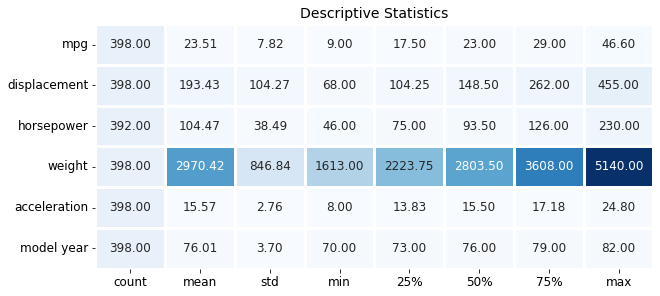

<IPython.core.display.Javascript object>

In [10]:
def desc_stats(dataframe):
    desc = dataframe.describe().T
    f,ax = plt.subplots(figsize=(10, desc.shape[0] * 0.75))
    sns.heatmap(desc,
                annot = True,
                cmap = "Blues",
                fmt= '.2f',
                ax = ax,
                linecolor = 'white',
                linewidths = 1.3,
                cbar = False,
                annot_kws = {"size": 12})
    plt.xticks(size = 12)
    plt.yticks(size = 12,
               rotation = 0)
    plt.title("Descriptive Statistics", size = 14)
    plt.show()
    
desc_stats(df[num_cols])

## EDA
### Analysis of Categorical Variables

In [11]:
def cat_summary(dataframe, col_name):
    
    get_labels = lambda x: x.value_counts().keys()
    get_values = lambda x: x.value_counts().values
    
    fig = make_subplots(rows = 1,cols = 2,
                        subplot_titles = ('Countplot','Percentages'),
                        specs = [[{"type": "xy"}, {'type':'domain'}]])

    fig.add_trace(go.Bar( y = get_values(dataframe[col_name]).tolist(), 
                          x = [str(i) for i in dataframe[col_name].value_counts().index], 
                          text = get_values(dataframe[col_name]).tolist(),
                          textfont = dict(size = 14),
                          name = col_name,
                          textposition = 'auto',
                          marker = dict(color = colors),
                          showlegend=False),
                  row = 1, col = 1)
    
    fig.add_trace(go.Pie(labels = get_labels(dataframe[col_name]),
                         values = get_values(dataframe[col_name]),
                         textfont = dict(size = 14),
                         textposition='auto',
                         showlegend = False,
                         name = col_name,
                         marker = dict(colors = colors)
                        ),
                  row = 1, col = 2)
    
    fig.update_layout(title={'text': col_name,
                             'y':0.9,
                             'x':0.5,
                             'xanchor': 'center',
                             'yanchor': 'top'},
                      template ='ggplot2')
    
    iplot(fig)

for col in cat_cols:
    cat_summary(df, col)

<IPython.core.display.Javascript object>

### Analysis of Numerical Variables

In [12]:
def num_summary(dataframe, col_name):
    fig = make_subplots(rows=1,cols=2,
                        subplot_titles=('Quantiles','Distribution'))

    fig.add_trace(go.Box(y=dataframe[col_name],
                         name = str(col_name),
                         showlegend = False,
                         marker_color = colors[1]),
                  row = 1, col = 1)
    
    fig.add_trace(go.Histogram(x = dataframe[col_name],
                               xbins = dict(start = dataframe[col_name].min(),
                                            end = dataframe[col_name].max()),
                               showlegend = False,
                               name = str(col_name),
                               marker=dict(color=colors[0],
                                           line = dict(color = '#DBE6EC',
                                                       width = 1))
                              ),
                  row = 1, col = 2)
    
    fig.update_layout(title = {'text': col_name,
                               'y':0.9,
                               'x':0.5,
                               'xanchor': 'center',
                               'yanchor': 'top'},
                      template = 'ggplot2')
    
    iplot(fig)

for i in num_cols:
    num_summary(df,i)

<IPython.core.display.Javascript object>

### TOP 10 Horsepower

In [13]:
fig = px.bar(df[['horsepower','make','name']]. \
             sort_values('horsepower', ascending = False)[:10],
             y = 'name',
             x = 'horsepower',
             text = 'horsepower',
             labels={'name':'',
                     'horsepower': 'Horsepower',
                     'make': ''},
             color = 'make',
             color_discrete_sequence = colors)

fig.update_layout(title= dict(text = 'TOP 10 Horsepower',
                              x = 0.5,
                              y = 0.95,
                              xanchor = 'center',
                              yanchor = 'top'),
                  xaxis = dict(title = 'Horsepower'),
                  yaxis = dict(categoryorder='total ascending'),
                  font=dict(family ='Verdana',
                            size = 14,
                            color = 'gray'),
                  template='ggplot2')

fig.show()


<IPython.core.display.Javascript object>

### TOP 10 Weight

In [14]:
fig = px.bar(df[['weight','make','name']]. \
             sort_values('weight', ascending = False)[:10],
             y = 'name',
             x = 'weight',
             text='weight',
             labels={'name':'',
                     'weight': 'Weight',
                     'make': ''},
             color = 'make',
             color_discrete_sequence = colors)

fig.update_layout(title= dict(text = 'TOP 10 Weight',
                              x = 0.5,
                              y = 0.95,
                              xanchor = 'center',
                              yanchor = 'top'),
                  xaxis = dict(title = 'Weight'),
                  yaxis = dict(categoryorder='total ascending'),
                  font=dict(family = 'Verdana',
                            size = 14,
                            color = 'gray'),
                  template='ggplot2')

fig.show()

<IPython.core.display.Javascript object>

### Horsepower - MPG - Cylinders

In [15]:
data = [go.Scatter(x = df['mpg'],
                   y = df['horsepower'],
                   mode = 'markers',
                   text=df['weight'],
                   marker=dict(size=10,
                               color = df['weight'],
                               showscale=True,
                               colorscale = 'Viridis',
                               colorbar = dict(title='Weight'),
                               opacity=0.8))]

layout = go.Layout(title=dict(text='Horsepower - MPG - Weight',
                              y=0.9,
                              x=0.5,
                              xanchor= 'center',
                              yanchor= 'top'),
                              xaxis = dict(title = 'MPG'),
                              yaxis = dict(title = 'Horsepower'),
                   template='ggplot2')

fig = go.Figure(data = data, layout = layout)
iplot(fig)

<IPython.core.display.Javascript object>

### Horsepower - MPG - Displacement - Weight

In [16]:
data = go.Scatter3d(x = df['horsepower'],
                    y = df['mpg'],
                    z = df['displacement'],
                    mode='markers', marker=dict(color=df['weight'],
                                                showscale=True,
                                                colorbar=dict(title='Weight'),
                                                colorscale = 'Viridis',
                                                opacity=0.3))

layout = go.Layout(title = dict(text='Horsepower - MPG - Displacement - Weight',
                                y=0.9,
                                x=0.5,
                                xanchor= 'center',
                                yanchor= 'top'),
                   scene = dict(xaxis = dict(title='Horsepower'),
                                yaxis = dict(title = 'MPG'),
                                zaxis = dict(title='Displacement')),
                   template='ggplot2')

fig = go.Figure(data=data,layout=layout)
iplot(fig)

<IPython.core.display.Javascript object>

### Pairwise Relationships

In [17]:
fig = go.Figure(data=go.Splom(dimensions=[dict(label='mpg',
                                               values=df['mpg']),
                                          dict(label='displacement',
                                               values=df['displacement']),
                                          dict(label='horsepower',
                                               values=df['horsepower']),
                                          dict(label='weight',
                                               values=df['weight']),
                                          dict(label='acceleration',
                                               values=df['acceleration']),
                                          dict(label='model year',
                                               values=df['model year'])],
                showupperhalf=True, 
                text=df['cylinders'],
                marker=dict(color = [colors[i] for i in df['cylinders']. \
                                     astype('category').cat.codes],
                            showscale = False,
                            opacity = 0.65)))

fig.update_layout(title = {'text': 'Pairwise Relationships by Cylinders',
                          'xanchor': 'center',
                          'yanchor': 'top',
                          'x': 0.5,
                          'y': 0.95},
                  width=950,
                  height=950,
                  template = 'ggplot2')

iplot(fig)

<IPython.core.display.Javascript object>

In [18]:

fig = go.Figure(data=go.Splom(dimensions=[dict(label='mpg',
                                               values=df['mpg']),
                                          dict(label='displacement',
                                               values=df['displacement']),
                                          dict(label='horsepower',
                                               values=df['horsepower']),
                                          dict(label='weight',
                                               values=df['weight']),
                                          dict(label='acceleration',
                                               values=df['acceleration']),
                                          dict(label='model year',
                                               values=df['model year'])],
                showupperhalf=True, 
                text=df['origin'],
                marker=dict(color = [colors[i] for i in df['origin']. \
                                     astype('category').cat.codes],
                            showscale = False,
                            opacity = 0.65)))

fig.update_layout(title = {'text': 'Pairwise Relationships by Origins',
                          'xanchor': 'center',
                          'yanchor': 'top',
                          'x': 0.5,
                          'y': 0.95},
                  width = 950,
                  height = 950,
                  template = 'ggplot2')

iplot(fig)

<IPython.core.display.Javascript object>

### Correlation Coefficients

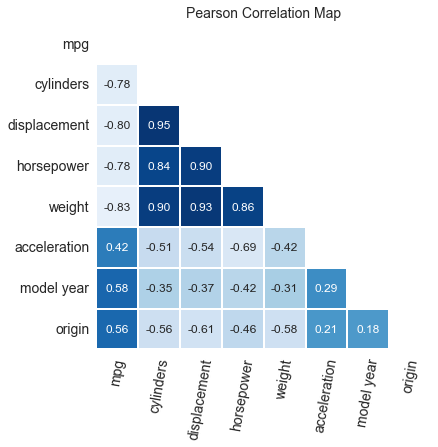

<IPython.core.display.Javascript object>

In [19]:
def corr_map(dataframe, method = 'pearson', title = None):
    assert method in ['pearson', 'spearman'], 'Invalid Correlation Method'
    sns.set_style("white")
    matrix = np.triu(dataframe.corr(method=method))
    f,ax=plt.subplots(figsize = (matrix.shape[0]*0.75,
                                 matrix.shape[1]*0.75))
    sns.heatmap(dataframe.corr(method=method),
                annot= True,
                fmt = ".2f",
                cbar = False,
                ax=ax,
                vmin = -1,
                vmax = 1,
                mask = matrix,
                cmap = "Blues",
                linewidth = 0.4,
                linecolor = "white",
                annot_kws={"size": 12})
    plt.xticks(rotation=80,size=14)
    plt.yticks(rotation=0,size=14)
    if title == None:
        title = f'{method.title()} Correlation Map'
    plt.title(title, size = 14)
    plt.show()
    
corr_map(df)


### Missing Values

In [20]:
def check_missing(dataframe):
    
    missing = pd.DataFrame({'Variable': dataframe.columns,
                           'Missing': [dataframe[i].isnull().sum() for i in dataframe.columns],
                           'Ratio': [100 * dataframe[i].isnull().sum() / dataframe.shape[0] \
                                    for i in dataframe.columns]})
    missing = missing[missing['Missing'] > 0]
    
    if missing.shape[0] == 0:
        print('No missing values')
    else:
        missing = missing.reset_index(drop = True)
        missing = missing.sort_values('Missing', ascending = False)
        return missing
    
check_missing(df)

,Variable,Missing,Ratio
0,horsepower,6,1.507538


<IPython.core.display.Javascript object>

In [21]:
df.groupby(cat_cols).agg({'horsepower': ['mean','median']})

horsepower       
                        mean median
cylinders origin                   
3         3        99.250000   98.5
4         1        80.956522   84.0
          2        78.311475   76.0
          3        75.579710   70.0
5         2        82.333333   77.0
6         1        99.671233  100.0
          2       113.500000  122.5
          3       115.833333  118.0
8         1       158.300971  150.0

<IPython.core.display.Javascript object>

In [22]:
df['horsepower'] = df['horsepower'].fillna(df.groupby(cat_cols)['horsepower'].transform('median'))

check_missing(df)

No missing values


<IPython.core.display.Javascript object>

### Outliers

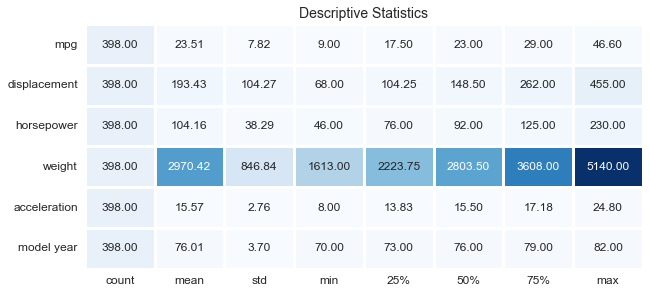

<IPython.core.display.Javascript object>

In [23]:
def outlier_thresholds(dataframe, col_name, q1 = 0.25, q3 = 0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def replace_with_thresholds(dataframe, variable, q1 = 0.25, q3 = 0.75):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1 = q1, q3 = q3)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in df[num_cols].columns:
    replace_with_thresholds(df, col, q1 = 0.1, q3 = 0.9)
    
desc_stats(df[num_cols])

## Feature Engineering

### MPG (Dependent Variable)

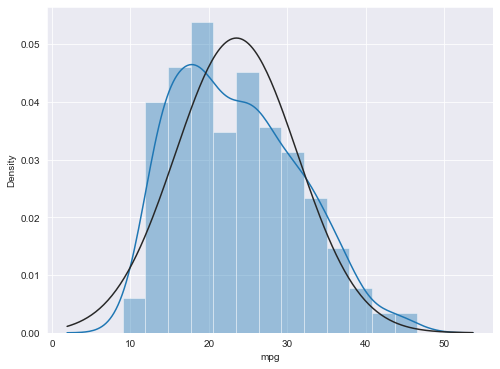

mu: 23.514572864321607 sigma = 7.806159061274433


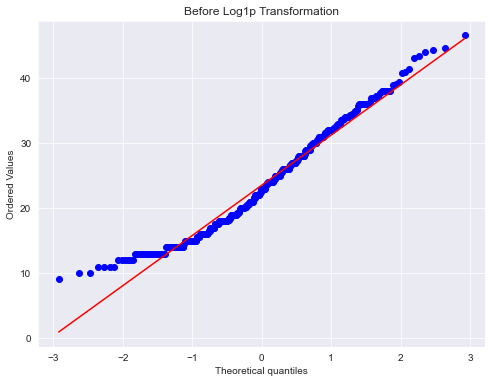

<IPython.core.display.Javascript object>

In [24]:
# 로그 변환 전
sns.set_style('darkgrid')
plt.figure(figsize = (8, 6))
sns.distplot(df.mpg, fit= norm)
plt.show()

(mu, sigma) = norm.fit(df["mpg"])

print("mu: {} sigma = {}".format(mu, sigma))

fig = plt.figure(figsize = (8,6))
stats.probplot(df["mpg"], plot = plt)
plt.title("Before Log1p Transformation", size = 12)
plt.show()

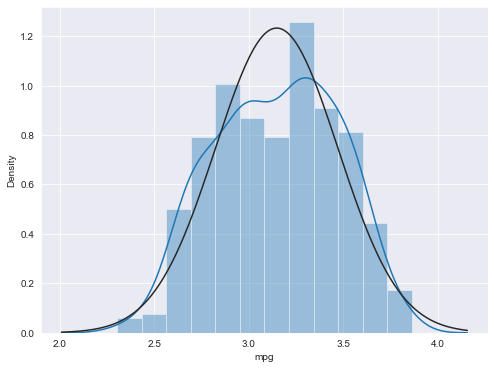

mu: 3.1478302770344047 sigma = 0.32375928015327066


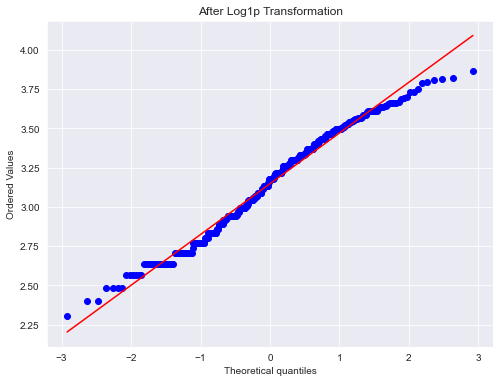

<IPython.core.display.Javascript object>

In [25]:
# 로그 변환 후
df["mpg"] = np.log1p(df["mpg"])
plt.figure(figsize = (8,6))
sns.distplot(df.mpg, fit= norm)
plt.show()

(mu, sigma) = norm.fit(df["mpg"])

print("mu: {} sigma = {}".format(mu, sigma))

fig = plt.figure(figsize = (8,6))
stats.probplot(df["mpg"], plot = plt)
plt.title("After Log1p Transformation", size = 12)
plt.show()

### Encoding

In [26]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe,
                               columns = categorical_cols,
                               drop_first = drop_first)
    return dataframe

# 왜 바이너리 컬럼에면 라벨 인코딩을 하는가?
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtype not in [int, float]
               and df[col].nunique() == 2]
print('Binary Variables: {}'.format(binary_cols))

ohe_cols = [col for col in df.columns if 10 >= df[col].nunique() > 2]
ohe_cols.append('make')
print('Multiclass Variables: {}'.format(ohe_cols))

Binary Variables: []
Multiclass Variables: ['cylinders', 'origin', 'make']


<IPython.core.display.Javascript object>

In [27]:
df['cylinders'] = df['cylinders'].astype(int)
df['origin'] = df['origin'].astype(int)
df = one_hot_encoder(df, ohe_cols)
df.head()

,mpg,displacement,horsepower,weight,acceleration,model year,name,cylinders_3,cylinders_4,cylinders_5,...,make_Peugeot,make_Plymouth,make_Pontiac,make_Renault,make_Saab,make_Subaru,make_Toyota,make_Triumph,make_Volkswagen,make_Volvo
0,2.944439,307.0,130.0,3504.0,12.0,70,Chevelle Malibu,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2.772589,350.0,165.0,3693.0,11.5,70,Skylark 320,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2.944439,318.0,150.0,3436.0,11.0,70,Satellite,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,2.833213,304.0,150.0,3433.0,12.0,70,Rebel Sst,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.890372,302.0,140.0,3449.0,10.5,70,Torino,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [28]:
check_class(df)

,Variable,Classes
0,weight,351
1,name,300
2,mpg,129
3,acceleration,95
4,horsepower,93
5,displacement,82
6,model year,13
7,make_Peugeot,2
8,make_Honda,2
9,make_Mazda,2


<IPython.core.display.Javascript object>

In [29]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 398
Variables: 45
cat_cols: 38
num_cols: 6
cat_but_car: 1
num_but_cat: 38


<IPython.core.display.Javascript object>

In [30]:
def rare_analyser(dataframe, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe)}), end="\n\n\n")

rare_analyser(df, cat_cols)

cylinders_3 : 2
   COUNT    RATIO
0    394  0.98995
1      4  0.01005


cylinders_4 : 2
   COUNT     RATIO
1    204  0.512563
0    194  0.487437


cylinders_5 : 2
   COUNT     RATIO
0    395  0.992462
1      3  0.007538


cylinders_6 : 2
   COUNT     RATIO
0    314  0.788945
1     84  0.211055


cylinders_8 : 2
   COUNT     RATIO
0    295  0.741206
1    103  0.258794


origin_1 : 2
   COUNT     RATIO
1    249  0.625628
0    149  0.374372


origin_2 : 2
   COUNT     RATIO
0    328  0.824121
1     70  0.175879


origin_3 : 2
   COUNT     RATIO
0    319  0.801508
1     79  0.198492


make_Amc : 2
   COUNT     RATIO
0    370  0.929648
1     28  0.070352


make_Audi : 2
   COUNT     RATIO
0    391  0.982412
1      7  0.017588


make_Bmw : 2
   COUNT     RATIO
0    396  0.994975
1      2  0.005025


make_Buick : 2
   COUNT     RATIO
0    381  0.957286
1     17  0.042714


make_Cadillac : 2
   COUNT     RATIO
0    396  0.994975
1      2  0.005025


make_Capri : 2
   COUNT     RATIO
0    397  

<IPython.core.display.Javascript object>

In [31]:
useless_cols = [col for col in df.columns if df[col].nunique() == 2 and
                (df[col].value_counts() / len(df) < 0.03).any(axis=None)]

print('Number of useless variables: {}'.format(len(useless_cols)))
df.drop(useless_cols, axis = 1, inplace=True)

Number of useless variables: 20


<IPython.core.display.Javascript object>

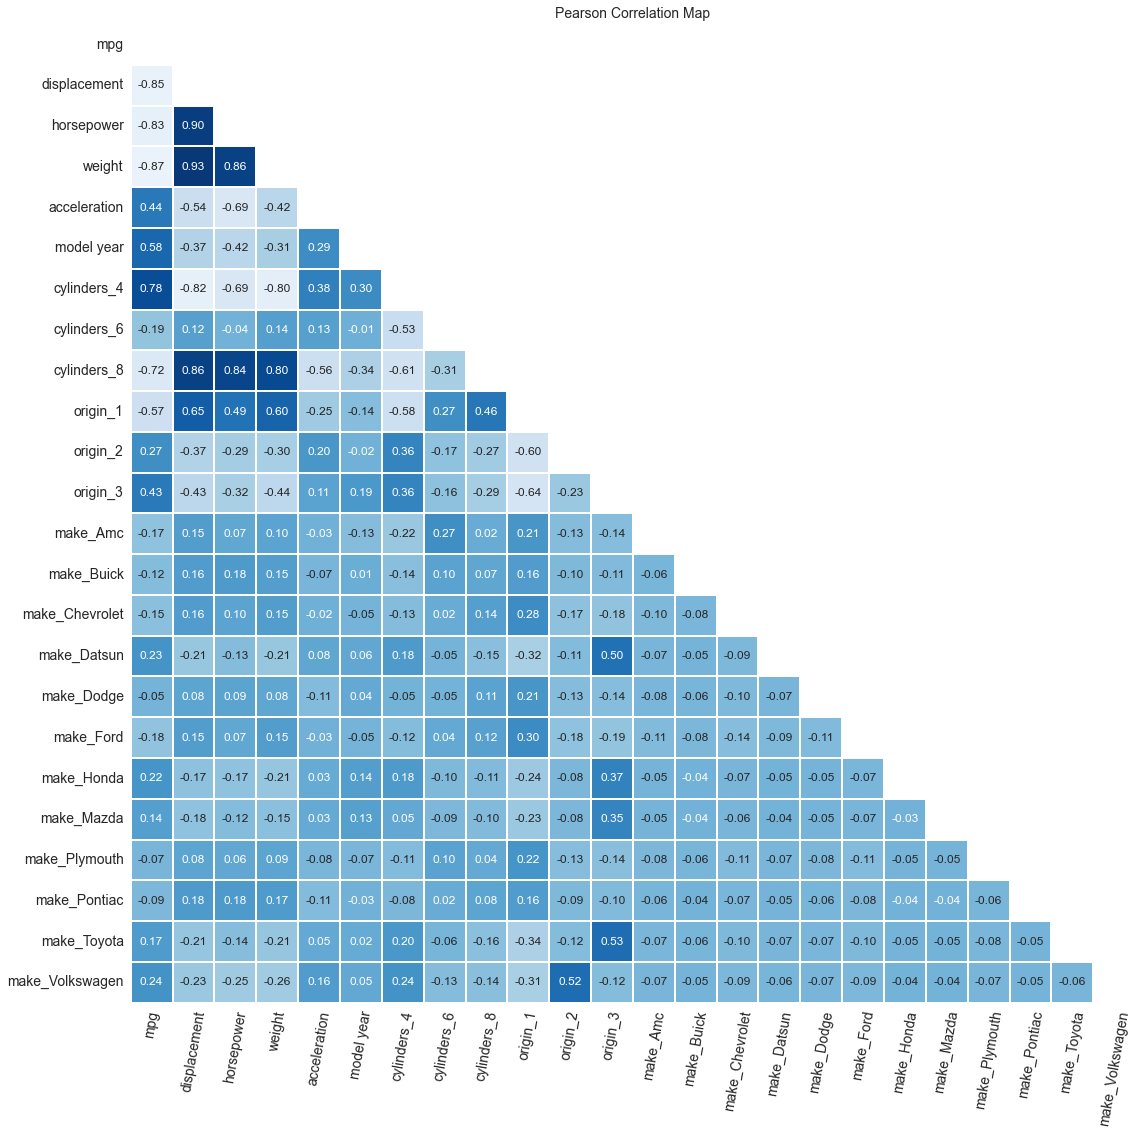

<IPython.core.display.Javascript object>

In [32]:
corr_map(df)

## Preprocessing

In [33]:
X = df.drop(columns = ["mpg", 'name'], axis = 1)
y = df['mpg']
X.head()

,displacement,horsepower,weight,acceleration,model year,cylinders_4,cylinders_6,cylinders_8,origin_1,origin_2,...,make_Chevrolet,make_Datsun,make_Dodge,make_Ford,make_Honda,make_Mazda,make_Plymouth,make_Pontiac,make_Toyota,make_Volkswagen
0,307.0,130.0,3504.0,12.0,70,0,0,1,1,0,...,1,0,0,0,0,0,0,0,0,0
1,350.0,165.0,3693.0,11.5,70,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,318.0,150.0,3436.0,11.0,70,0,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
3,304.0,150.0,3433.0,12.0,70,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,302.0,140.0,3449.0,10.5,70,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [34]:
test_size = 0.2
random_state = 42
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size  = test_size,
                                                    random_state = random_state)

<IPython.core.display.Javascript object>

### Modeling

In [35]:
def train_pipeline(pipe):
    
    scaler = pipe.steps[0][1].__class__.__name__
    regressor = pipe.steps[1][1].__class__.__name__
    if scaler == 'NoneType':
        scaler = 'Without Scaling'
    
    #Fitting Model
    pipe.fit(X_train, y_train)
    
    #Get Predictions
    y_pred = pipe.predict(X_test)
    y_test_exp = np.expm1(y_test)
    y_pred_exp = np.expm1(y_pred)
    
    #Model Evaluation
    r2 = r2_score(y_test_exp, y_pred_exp)
    mse = mean_squared_error(y_test_exp, y_pred_exp)
    rmse = mean_squared_error(y_test_exp, y_pred_exp, squared = False)
    msle = mean_squared_log_error(y_test_exp, y_pred_exp)
    mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp)
    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    return scaler, regressor, r2, mse, rmse, msle, mape, mae
    
regressors = [KNeighborsRegressor(),
              LinearRegression(),
              Lasso(),
              Ridge(),
              ElasticNet(),
              XGBRegressor(),
              LGBMRegressor(),
              AdaBoostRegressor(),
              SVR(),
              RandomForestRegressor(),
              DecisionTreeRegressor()]

scalers = [None, StandardScaler(), RobustScaler()]
eval_data = pd.DataFrame({'model': [],
                          'scaler': [],
                          'r2': [],
                          'mse': [],
                          'rmse': [],
                          'msle': [],
                          'mape': [],
                          'mae': []})
for reg in regressors:
    for sc in scalers:
        pipeline = Pipeline([('scaler', sc), ('reg', reg)])
        scaler, regressor, r2, mse, rmse, msle, mape, mae = train_pipeline(pipeline)
        eval_data = eval_data.append(pd.DataFrame({'model': [regressor],
                                                   'scaler': [scaler],
                                                   'r2': [r2],
                                                   'mse': [mse],
                                                   'rmse': [rmse],
                                                   'msle': [msle],
                                                   'mape': [mape],
                                                   'mae': [mae]}))
    eval_data = eval_data.reset_index(drop = True)
eval_data.sort_values('rmse')


,model,scaler,r2,mse,rmse,msle,mape,mae
27,RandomForestRegressor,Without Scaling,0.914741,4.584086,2.141048,0.008166,0.070252,1.547524
25,SVR,StandardScaler,0.910131,4.831960,2.198172,0.008995,0.079895,1.742404
9,Ridge,Without Scaling,0.909820,4.848648,2.201965,0.009797,0.076822,1.624131
28,RandomForestRegressor,StandardScaler,0.909690,4.855634,2.203550,0.008062,0.072038,1.621813
26,SVR,RobustScaler,0.909531,4.864196,2.205492,0.008928,0.077681,1.695063
11,Ridge,RobustScaler,0.907956,4.948894,2.224611,0.009943,0.077045,1.635173
20,LGBMRegressor,RobustScaler,0.907853,4.954427,2.225854,0.008973,0.078863,1.743778
4,LinearRegression,StandardScaler,0.907526,4.972010,2.229800,0.009955,0.077532,1.640542
5,LinearRegression,RobustScaler,0.907526,4.972010,2.229800,0.009955,0.077532,1.640542
3,LinearRegression,Without Scaling,0.907526,4.972010,2.229800,0.009955,0.077532,1.640542


<IPython.core.display.Javascript object>

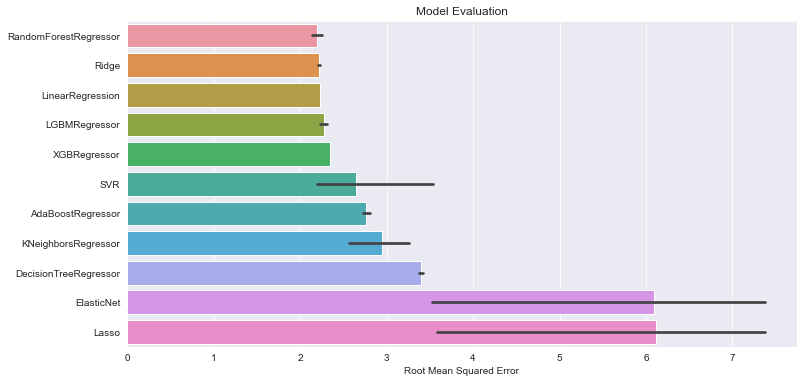

<IPython.core.display.Javascript object>

In [36]:
sns.set_style('darkgrid')
plt.figure(figsize = (12, 6))
plt.title('Model Evaluation', size = 12)
sns.barplot(data = eval_data,
            y = 'model',
            x = 'rmse',
            order = eval_data.groupby('model').\
            agg({'rmse': 'mean'}).\
            reset_index().\
            sort_values('rmse').model)
plt.ylabel('')
plt.xlabel('Root Mean Squared Error', size = 10)
plt.show()